In [3]:
from torchvision import datasets # MNIST datasets
from torchvision.transforms import ToTensor # transform PIL image to torch.Tensor
from torch import nn # neural network library
import torch
import matplotlib.pyplot as plt # print image
from torch.utils.data import DataLoader # mini-batch loader
import torch.nn.functional as F
import numpy as np
import math

In [4]:
!nvidia-smi

Thu Oct 20 12:46:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# training set
train_ds = datasets.MNIST('./data', train=True, download=True, transform=ToTensor())
# test set
test_ds = datasets.MNIST('./data', train=False, download=True, transform=ToTensor())

print(f"train {len(train_ds)} test {len(test_ds)}")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

train 60000 test 10000


In [6]:
# the first training sample
x, y = train_ds[0]
print("input type", type(x))
print("input size", x.shape)
print("output type", type(y))
print("target", y)

input type <class 'torch.Tensor'>
input size torch.Size([1, 28, 28])
output type <class 'int'>
target 5


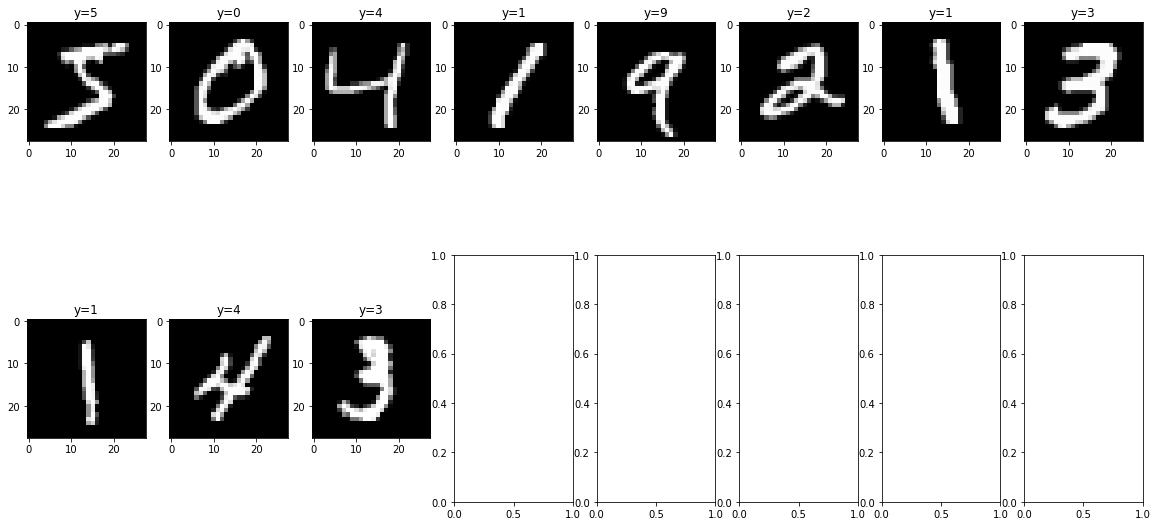

In [7]:
# plot a grid of samples with targets
def plot_grid(ds, n):
    ncols = 8
    nrows = n // ncols + 1
    plt.subplots(nrows, ncols, figsize=(20, 10))
    for i, (x, y) in enumerate(ds):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(x[0], cmap="gray")
        plt.title(f'y={y:01d}')
        if i >= n: 
            break

plot_grid(train_ds, 10)

## CNN basic

![picture](https://drive.google.com/uc?id=1Jz1tllPTE9y4klj7zlMA0TwlAz6jAMYN)

In [30]:
class CNN_Basic(nn.Module):
    def __init__(self):
        super(CNN_Basic, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(3136, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.relu2(x)
        x = self.dropout1(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [31]:
# user DataLoader to create mini-batch
batch_size = 16

# training dataloader (with shuffling)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

# test dataloader (no shuffling)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# Checking the dataset
for images, labels in train_dataloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([16, 1, 28, 28])
Image label dimensions: torch.Size([16])


In [32]:
# test model with inputs
model = CNN_Basic() # MLP

# model = resnet18(num_classes=10, grayscale=True) # resnet

# define cross entropy loss
loss_func = nn.CrossEntropyLoss()

# use Stochastic Gradient Descent optimizer
arr_lr = [0.1, 0.01, 0.001]
lr = arr_lr[1] # change learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:
# train with GPU
n_epoch = 5

# change epoch 
arr_num_epoch = [5, 10, 50, 100]
for num_ep in arr_num_epoch:
    print('-'*50)
    print(f'Number of epoch: {num_ep}\nLearning rate: {lr} -- Batch size: {batch_size}')
    n_epoch = num_ep
    model.cuda()
    for epoch in range(n_epoch):

        # training phase
        model.train()
        print(f"epoch {epoch} started")
        for x, y in train_dataloader:
            # compute output of the model on the mini-batch
            x = x.cuda()
            out = model(x)

            # compute loss function
            loss = loss_func(out, y.cuda())

            # calculate derivative and do a gradient descent step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # testing phase
        model.eval()
        total = len(test_ds)
        total_correct = 0 # count number of correct predictions on test set

        for x, y in test_dataloader:
            with torch.no_grad(): # prevent gradient computation
                x = x.cuda()
                out = model(x)
                # take the maximum output
                pred = torch.argmax(out, dim=1)
                # count the correct predictions
                corrects = (pred == y.cuda()).sum().item()
                total_correct += corrects

        # compute test accuracy for this epoch
        accuracy = total_correct / total
        print(f"epoch {epoch} accuracy {accuracy*100:.2f}%")
    break

--------------------------------------------------
Number of epoch: 5
Learning rate: 0.01 -- Batch size: 16
epoch 0 started
epoch 0 accuracy 98.41%
epoch 1 started
epoch 1 accuracy 98.83%
epoch 2 started
epoch 2 accuracy 98.90%
epoch 3 started
epoch 3 accuracy 99.07%
epoch 4 started
epoch 4 accuracy 99.24%


In [34]:
# calculate prediction on test set
ypred = []
targets = []
model.eval()
with torch.no_grad():
    for x, y in test_ds:
        
        # this is the code to do inference
    #     x = x.view(len(x), -1).cuda()
        x = x.unsqueeze(0).cuda() # append batch size
        out = model(x)
        pred = torch.argmax(out, dim=1).item()

        # append the prediction results
        ypred.append(pred)
        targets.append(y)
n_incorrect = sum([x != y for x, y in zip(targets, ypred)])
print("n_INCORRECT", n_incorrect)

n_INCORRECT 76


## Densenet

![picture](https://editor.analyticsvidhya.com/uploads/254293.png) DenseNet Architecture

![picture](https://amaarora.github.io/images/densenet.png) 
Single layer

In [35]:
class SingleLayer(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        # implement here
        # shape (batch_size, nChannels, num_feature, num_feature) -> (batch_size, growthRate, num_feature, num_feature)
        # ex: batch_size - 16, nChannels = 24, growthRate = 12: (16, 24, 28, 28) -> (16, 12, 28, 28)
        out = self.conv1(F.relu(self.bn1(x)))
        # shape (batch_size, growthRate, num_feature, num_feature) -> (batch_size, (growthRate + nChannels), num_feature, num_feature)
        out = torch.cat((x, out), 1)
        return out

In [ ]:
# test
torch.manual_seed(20)
x = torch.rand(16,24,28,28)
layer = SingleLayer(24, 12)
layer(x)

![picture](https://drive.google.com/uc?id=1glh6rRmIleGiNlN56_fPlA_TVd731uPD)
Bottle Neck layer

In [36]:
class Bottleneck(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(Bottleneck, self).__init__()
        interChannels = 4*growthRate
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, interChannels, kernel_size=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        # implement here
        # shape (batch_size, nChannels, num_feature, num_feature) -> (batch_size, growthRate*4, num_feature, num_feature)
        out = self.conv1(F.relu(self.bn1(x)))
        # shape (batch_size, growthRate*4, num_feature, num_feature) -> (batch_size, growthRate, num_feature, num_feature)
        out = self.conv2(F.relu(self.bn2(out)))
        # shape (batch_size, growthRate, num_feature, num_feature) -> (batch_size, (nChannels +growthRate), num_feature, num_feature)
        out = torch.cat((x, out), 1)
        return out

In [ ]:
# test
torch.manual_seed(20)
x = torch.rand(16,24,28,28)
layer = Bottleneck(24, 12)
layer(x)

In [37]:
class Transition(nn.Module):
    def __init__(self, nChannels, nOutChannels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, nOutChannels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [41]:
class DenseNet(nn.Module):
    def __init__(self, growthRate, depth, reduction, nClasses, bottleneck):
        """
        Parameters:
            reduction: number of feature keep in a Block
        """
        super(DenseNet, self).__init__()

        nDenseBlocks = (depth-4) // 3
        if bottleneck:
            nDenseBlocks //= 2

        nChannels = 2*growthRate
        self.conv1 = nn.Conv2d(1, nChannels, kernel_size=3, padding=1,
                               bias=False)
        self.dense1 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans1 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense2 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans2 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense3 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.fc = nn.Linear(nChannels, nClasses)

        
        # initialize bias and weight for each type of module
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_dense(self, nChannels, growthRate, nDenseBlocks, bottleneck):
        layers = []
        for i in range(int(nDenseBlocks)):
            if bottleneck:
                layers.append(Bottleneck(nChannels, growthRate))
            else:
                layers.append(SingleLayer(nChannels, growthRate))
            nChannels += growthRate
        return nn.Sequential(*layers)

    def forward(self, x):
        # implement code here
        # Example for one batch
        # shape (16, 1, 28, 28) -> (16, 24, 28, 28) conv1
        out = self.conv1(x)

        # dense layer -> trans layer
        # shape (16, 24, 28, 28) -> (16, 246, 14, 14) trans1
        out = self.trans1(self.dense1(out))

        # dense layer -> trans layer
        # shape (16, 246, 14, 14)  -> [16, 357, 7, 7] trans2
        out = self.trans2(self.dense2(out))

        # shape [16, 357, 7, 7] -> [16, 825, 7, 7] dense3
        out = self.dense3(out)

        # BatchNorm -> Relu -> AvgPool2d
        # shape [16, 825, 7, 7] -> [16, 825]
        out = torch.squeeze(F.avg_pool2d(F.relu(self.bn1(out)), 8))
        # shape [16, 825] -> [16, 10]
        out = F.log_softmax(self.fc(out))
        return out

### Train Densenet with MMINST

In [42]:
# test model with inputs
model = DenseNet(growthRate=12, depth=121, reduction=0.5, nClasses=10, bottleneck=False) # MLP

# model = resnet18(num_classes=10, grayscale=True) # resnet

# define cross entropy loss
loss_func = nn.CrossEntropyLoss()

# use Stochastic Gradient Descent optimizer
arr_lr = [0.1, 0.01, 0.001]
lr = arr_lr[1] # change learning_rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
# train with GPU
n_epoch = 5

# change epoch 
arr_num_epoch = [5, 10, 50, 100]
for num_ep in arr_num_epoch:
    print('-'*50)
    print(f'Number of epoch: {num_ep}\nLearning rate: {lr} -- Batch size: {batch_size}')
    n_epoch = num_ep
    model.cuda()
    for epoch in range(n_epoch):

        # training phase
        model.train()
        print(f"epoch {epoch} started")
        for x, y in train_dataloader:
            # compute output of the model on the mini-batch
            x = x.cuda()
            out = model(x)
            # compute loss function
            loss = loss_func(out, y.cuda())

            # calculate derivative and do a gradient descent step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # testing phase
        model.eval()
        total = len(test_ds)
        total_correct = 0 # count number of correct predictions on test set

        for x, y in test_dataloader:
            with torch.no_grad(): # prevent gradient computation
                x = x.cuda()
                out = model(x)
                # take the maximum output
                pred = torch.argmax(out, dim=1)
                # count the correct predictions
                corrects = (pred == y.cuda()).sum().item()
                total_correct += corrects

        # compute test accuracy for this epoch
        accuracy = total_correct / total
        print(f"epoch {epoch} accuracy {accuracy*100:.2f}%")
    break

#Excercises
1. Try ResNet18, ResNet34, ResNet50. What are differences once using these backbones? 
2. Try InceptionNet
3. What is Conv1x1? What is its advantages?

In [1]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [9]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [10]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, grayscale=False):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # MNIST is already 1x1 disable avgpool
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [11]:
def resnet18(num_classes, grayscale):
    """Constructs a ResNet-18 model."""
    model = ResNet(BasicBlock, layers=[2, 2, 2, 2], num_classes=num_classes, grayscale=grayscale)
    return model

def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, grayscale=grayscale)
    return model

def resnet50(num_classes, grayscale):
    """Constructs a ResNet-50 model."""
    model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, grayscale=grayscale)
    return model

In [12]:
batch_size = 16
train_dataset = datasets.MNIST(root='data', train=True, transform=ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=ToTensor())


train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Checking the dataset
for images, labels in train_dataloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([16, 1, 28, 28])
Image label dimensions: torch.Size([16])


In [15]:
model = resnet18(10, True) # resnet
arr_lr = [0.1, 0.01, 0.001]
lr = arr_lr[1] # change learning_rate
loss_func = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  

In [16]:
# train with GPU
n_epoch = 5

# change epoch 
arr_num_epoch = [5, 10, 50, 100]
for num_ep in arr_num_epoch:
    print('-'*50)
    print(f'Number of epoch: {num_ep}\nLearning rate: {lr} -- Batch size: {batch_size}')
    n_epoch = num_ep
    model.cuda()
    for epoch in range(n_epoch):

        # training phase
        model.train()
        print(f"epoch {epoch} started")
        for x, y in train_dataloader:
            # compute output of the model on the mini-batch
            x = x.cuda()
            out = model(x)
            # compute loss function
            loss = loss_func(out, y.cuda())

            # calculate derivative and do a gradient descent step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # testing phase
        model.eval()
        total = len(test_ds)
        total_correct = 0 # count number of correct predictions on test set

        for x, y in test_dataloader:
            with torch.no_grad(): # prevent gradient computation
                x = x.cuda()
                out = model(x)
                # take the maximum output
                pred = torch.argmax(out, dim=1)
                # count the correct predictions
                corrects = (pred == y.cuda()).sum().item()
                total_correct += corrects

        # compute test accuracy for this epoch
        accuracy = total_correct / total
        print(f"epoch {epoch} accuracy {accuracy*100:.2f}%")
    break

--------------------------------------------------
Number of epoch: 5
Learning rate: 0.01 -- Batch size: 16
epoch 0 started
epoch 0 accuracy 98.26%
epoch 1 started
epoch 1 accuracy 98.84%
epoch 2 started
epoch 2 accuracy 98.47%
epoch 3 started
epoch 3 accuracy 96.48%
epoch 4 started
epoch 4 accuracy 98.43%
